This is a simple LSTM test with the goal to train to predict a sine wave using PyTorch.

In [11]:
# Created by Davide Pasca - 2023/07/25

import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [12]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

print("Using device:", device)

Using device: mps


In [13]:
# Constants
SAMPLE_SIZE_MINS = 60 * 6  # 6 hours
USE_LOG_RETURNS = True

# If true, just generate a sine wave
USE_SYNTETIC_DATA = False

LSTM_INPUT_SIZE = 1  # Only 1 feature (univariate time series data)
LSTM_SEQUENCE_LENGTH = SAMPLE_SIZE_MINS * 6 // 60
LSTM_LAYERS_N = 2
# https://www.quora.com/How-should-I-set-the-size-of-hidden-state-vector-in-LSTM-in-keras/answer/Yugandhar-Nanda
LSTM_HIDDEN_SIZE = LSTM_SEQUENCE_LENGTH * 2

LEARNING_RATE_ADAM = 0.001
LEARNING_RATE_ADAGRAD = 0.01
LEARNING_RATE_RMS_PROP = 0.0001
LEARNING_RATE_SGD = 0.01

L2_WEIGHT_DECAY = 0.0 # 0.0001

EPOCHS_N = 5000

In [14]:
def normalizeVal(val):
    return val / 4.0
    #return val

def denormalizeVal(val):
    return val * 4.0
    #return val

def generate_sine_wave(samplesN: int, frequency: float, minVal: float, maxVal: float) -> torch.Tensor:
    amp = (maxVal - minVal) / 2.0
    wave = [float(amp * (math.sin(2.0 * math.pi * frequency * i) + 1.0) + minVal) for i in range(samplesN)]
    return torch.tensor(wave)

def safeLog(vals: torch.Tensor) -> torch.Tensor:
    return torch.where(vals > 0, torch.log(vals), torch.tensor(0.0))

def make_input_data(vals: torch.Tensor) -> torch.Tensor:
    data = torch.empty_like(vals)  # create an empty tensor of the same size
    if USE_LOG_RETURNS:
        data[1:] = normalizeVal(safeLog(vals[1:] / vals[:-1]))
        data[0] = data[1]  # copy the second element to the first
    else:
        data = normalizeVal(vals)
    return data

def create_sequences(data, seq_len):
    seqs_batch_n = len(data) - seq_len - 1
    sequences = torch.empty((seqs_batch_n, seq_len, 1))
    targets = torch.empty((seqs_batch_n, 1))
    for i in range(seqs_batch_n):
        sequences[i] = data[i:i + seq_len].view(seq_len, 1)
        targets[i] = data[i + seq_len + 1]
    return sequences, targets

In [15]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size, layers_n):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers_n)
        #self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(1), self.lstm.hidden_size, device=x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(1), self.lstm.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out.select(1, -1)  # Select the last element from the seq_len dimension
        #out = self.batch_norm(out)
        out = self.linear(out)
        out = out.squeeze(-1)  # Squeeze the last dimension if your output size is 1
        return out


In [16]:
import requests
import json
import time
import datetime

def get_klines_req(symbol, interval, start_time, limit=500):
    url = 'https://api.binance.com/api/v3/klines'
    
    # Define the parameters
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }

    response = requests.get(url, params=params)
    data = json.loads(response.text)

    # Convert the data to a more readable format
    readable_data = []
    for candle in data:
        time_stamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(candle[0]/1000))
        ohlcv = candle[1:6]
        readable_candle = [time_stamp] + ohlcv
        readable_data.append(readable_candle)

    return readable_data

def get_klines(symbol, interval, start_date, end_date):
    # Convert the start and end dates to milliseconds
    start_time = int(start_date.timestamp() * 1000)
    end_time = int(end_date.timestamp() * 1000)

    # Fetch historical data for Bitcoin with 6 hours candles
    btc_data = []
    while True:
        new_data = get_klines_req(symbol, interval, start_time)
        if not new_data:
            break
        last_time = new_data[-1][0]
        last_time_dt = datetime.datetime.strptime(last_time, '%Y-%m-%d %H:%M:%S')
        last_time_millis = int(last_time_dt.timestamp() * 1000)
        if last_time_millis >= end_time:
            # Clamp candles that go beyond the end date
            new_data = [candle for candle in new_data if int(datetime.datetime.strptime(candle[0], '%Y-%m-%d %H:%M:%S').timestamp() * 1000) < end_time]
        btc_data += new_data
        if last_time_millis >= end_time:
            break
        start_time = last_time_millis + 1
        time.sleep(0.1)  # delay to avoid hitting rate limits

    return btc_data

In [17]:
import os
import pickle

def get_closing_prices_in_range(start_YMD, end_YMD):
    start_date = datetime.datetime.strptime(start_YMD, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_YMD, '%Y-%m-%d')

    # Create a cache directory if it doesn't exist
    cache_dir = '_cache'
    os.makedirs(cache_dir, exist_ok=True)

    # Create a cache file name based on the start and end dates
    cache_file = os.path.join(cache_dir, 'btc_usdt_binance_data_{}_{}.pickle'.format(start_YMD, end_YMD))

    # Check if the cache file exists
    if os.path.exists(cache_file):
        # If the cache file exists, load the data from the file
        with open(cache_file, 'rb') as f:
            btc_data = pickle.load(f)
    else:
        # If the cache file doesn't exist, fetch the data and save it to the cache file
        btc_data = get_klines('BTCUSDT', '6h', start_date, end_date)
        with open(cache_file, 'wb') as f:
            pickle.dump(btc_data, f)

    return [float(candle[4]) for candle in btc_data]

# Split the data into training and test sets
train_prices = torch.tensor(get_closing_prices_in_range('2018-01-01', '2021-12-31'))
test_prices = torch.tensor(get_closing_prices_in_range('2022-01-01', '2022-10-01'))

In [18]:
torch.manual_seed(0)

# Setup data for training
train_input_data = make_input_data(train_prices)
train_seqs, train_targets = create_sequences(train_input_data, LSTM_SEQUENCE_LENGTH)
train_seqs = train_seqs.to(device)
train_targets = train_targets.to(device)

# Setup data for testing
test_input_data = make_input_data(test_prices)
test_seqs, test_targets = create_sequences(test_input_data, LSTM_SEQUENCE_LENGTH)
test_seqs = test_seqs.to(device)
test_targets = test_targets.to(device)

In [19]:
# use the Xavier scaling for initialization. Very effective in this case.
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    elif type(m) == nn.LSTM:
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

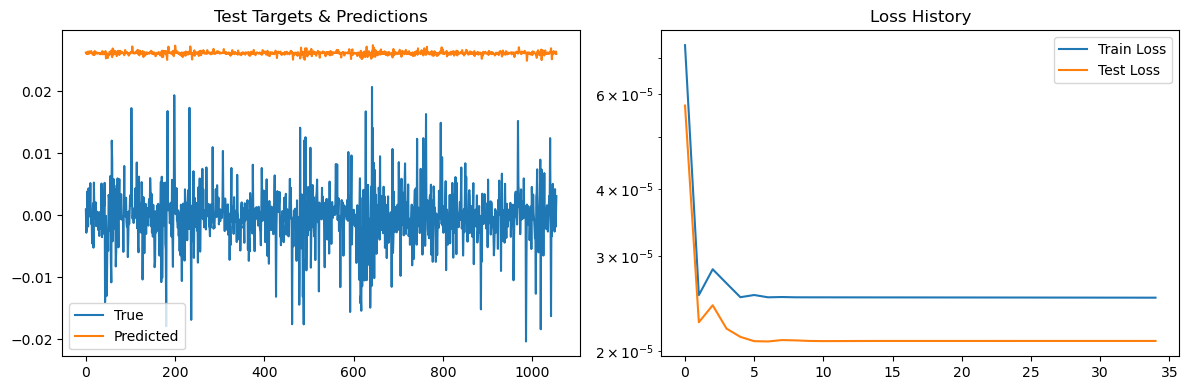

Epoch [350/5000], Train Loss: 0.000025, Test Loss: 0.000021


In [20]:
# Initialize the model
net = Network(LSTM_INPUT_SIZE, LSTM_HIDDEN_SIZE, LSTM_LAYERS_N)
net.apply(init_weights)
net = net.to(device)

# Specify loss function and optimizer
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE_ADAM, weight_decay=L2_WEIGHT_DECAY) # Bad
#optimizer = optim.Adagrad(net.parameters(), lr=LEARNING_RATE_ADAGRAD, weight_decay=L2_WEIGHT_DECAY) # OK
#optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE_SGD, momentum=0.9, weight_decay=L2_WEIGHT_DECAY) # Wobbly
#optimizer = optim.RMSprop(net.parameters(), lr=LEARNING_RATE_RMS_PROP, weight_decay=L2_WEIGHT_DECAY) # OK

#loss_func = nn.L1Loss(reduction='mean')
loss_func = nn.MSELoss(reduction='mean')

# Track the loss history for both training and testing
train_loss_history = []
test_loss_history = []

# Training loop
for epoch in range(EPOCHS_N):
    train_preds = net(train_seqs)
    train_loss = loss_func(train_preds, train_targets.squeeze(-1))
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        net.eval()  # Switch to evaluation mode
        with torch.no_grad():
            test_preds = net(test_seqs)
            test_loss = loss_func(test_preds, test_targets.squeeze(-1))
            
        train_loss_history.append(train_loss.item())
        test_loss_history.append(test_loss.item())
        
        test_preds_vec = []
        for i in range(len(test_seqs)):
            sequence = test_seqs[i].unsqueeze(0)
            pred = net(sequence).item()
            test_preds_vec.append(denormalizeVal(pred))

        # Clear previous plots
        clear_output(wait=True)

        # Create a figure
        fig, axs = plt.subplots(1, 2, figsize=(12,4))

        # Plot the targets and predictions
        axs[0].plot(test_targets.cpu().numpy(), label='True')
        axs[0].plot(test_preds_vec, label='Predicted')
        axs[0].set_title('Test Targets & Predictions')
        axs[0].legend()

        # Plot the loss history
        axs[1].plot(train_loss_history, label='Train Loss')
        axs[1].plot(test_loss_history, label='Test Loss')
        axs[1].set_title('Loss History')
        axs[1].legend()

        # Set y-axis to logarithmic scale for loss history
        axs[1].set_yscale('log')

        plt.tight_layout()
        plt.show()

        print(f"Epoch [{epoch+1}/{EPOCHS_N}], Train Loss: {train_loss.item():.6f}, Test Loss: {test_loss.item():.6f}")

        net.train()  # Switch back to training mode
